# Optimal control

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import scipy as sp
from scipy.sparse import coo_matrix
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

Q-CTRL package update available. Your version is 18.1.1. New version is 18.4.0.


In [2]:
# q_in, q_switch, q_out1, q_out2

EJs = [13.41, 12.52, 8.94, 12.52]
# EJs = [12.109, 11.195, 7.997, 11.195]
# EJs = [17.523, 16.450, 11.622, 16.450]

ECs = [0.237, 0.133, 0.270, 0.215]

# gs = [0.0827, 0.0787, 0.0652] # g12, g23, g24
gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# gs = [0.0613, 0.0600, 0.0475] # g12, g23, g24

In [3]:
cutoffs = [3, 4, 3, 3]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    is2Q=True,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)

qubit freqs (GHz) 4.79254700717944 3.5114496364265655
alphas (GHz) -0.26947045434385686 -0.1461765167455784


Optimizer parameters

In [4]:
# All units in GHz/ns

dims = qram.cutoffs
krylov_dims = 30 # Sparse representation dimensions
gate_duration = 300 # [ns]
max_drive_q = 0.050 # Max drive for qubit pulses
max_drive_sb = 0.150 # Max drive for sb pulses
num_opt_vars_q = 32
num_segments_q = 1000
num_opt_vars_sb = 32
num_segments_sb = 1000

# sinc cutoff defines I, Q frequency
# should be << wq since drive amplitude is just modulating the rotating terms
sinc_cutoff_q = 2*np.pi*10/gate_duration # [GHz]
print('sinc_cutoff_q', sinc_cutoff_q/2/np.pi)
print(f'Need {4/gate_duration} < sinc cutoff q < {num_segments_q/gate_duration}')

sinc_cutoff_sb = 2*np.pi*10/gate_duration # [GHz]
print('sinc_cutoff_sb', sinc_cutoff_sb/2/np.pi)
print(f'Need {4/gate_duration} < sinc cutoff sb < {num_segments_sb/gate_duration}')

freq_sb = 2*qubit_freqs[1] + alphas[1] - qubit_freqs
# freq_sb_rot = freq_sb - qubit_freqs # sideband frequency in the interaction picture
print(freq_sb)

sinc_cutoff_q 0.03333333333333333
Need 0.013333333333333334 < sinc cutoff q < 3.3333333333333335
sinc_cutoff_sb 0.03333333333333333
Need 0.013333333333333334 < sinc cutoff sb < 3.3333333333333335
[2.08417575 3.36527312]


Define qctrl hamiltonian and drive terms

Applies drive term $\sum_q (\gamma_q(t)e^{i\omega_qt}a_q + h.c.) + \sum_q (\epsilon_q(t)e^{i\omega_{SB}t}a_q + h.c.)$

$\gamma_j(t), \epsilon_j(t)=I_j(t)\sin(\omega_j t)+Q_j(t)\cos(\omega_j t)$

<!-- $\gamma_q$ will be filtered to be near the $\omega_{01}$ of qubit $q$, $\epsilon_q$ will be filtered to be near the sideband pulse for $|eg\rangle\to|gf\rangle$ with the first qubit being qubit $q$. -->

<!-- Since we are in the rotating frame of the qubit frequencies, apply a sinc cutoff for the qubit pulses and a gaussian bandlimit for the sideband pulses. -->
Everything done relative to frame given by frame_freq!

In [5]:
def setup_graph(graph, frame_freq):
    output_node_names = []

    # enforces endpoints of I, Q to be 0
    # I still don't understand how this works
    envelope_q = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_q))
    envelope_sb = 1 - np.abs(np.linspace(-1.0, 1.0, num_opt_vars_sb))

    # Bandlimit the qubit pulses
    sinc_kernel_q = graph.sinc_convolution_kernel(sinc_cutoff_q)
    sinc_kernel_sb = graph.sinc_convolution_kernel(sinc_cutoff_sb)

    # Set up optimizer variables for [I, Q] component of drive

    drives = []
    t = graph.identity_stf() # f(t) = t

    # Single qubit drives
    for q in range(qram.nqubits):
        drive_signals = [] # I, Q
        for j in range(2): # I, Q
            drive_vars = graph.optimization_variable(
                count=num_opt_vars_q,
                lower_bound=-max_drive_q,
                upper_bound=max_drive_q,
            )
            drive_vars = drive_vars * envelope_q

            # Build the pulse signal with segments based on the optimizer variables
            drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
            drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernel_q)

            # Discretize the filtered drive into the desired number of segments
            drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments_q)
            drive_signal.name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
            output_node_names.append(drive_signal.name)
            drive_signals.append(drive_signal)

        # hermitian_part(A) returns 1/2 (A + A^(dag))
        wq_exp = graph.exp(1j*2*np.pi*(qubit_freqs[q]-frame_freq)*t)
        wq_exp_stf = graph.discretize_stf(stf=wq_exp, duration=gate_duration, segment_count=num_segments_q)
        drives.append(
            graph.sparse_pwc_hermitian_part(
                graph.sparse_pwc_operator(
                    signal=(-1j*drive_signals[0]+drive_signals[1]) * wq_exp_stf,
                    operator=coo_matrix(qram.a_ops[q].data)
                    )
                )
            ) # drive on qubit q

    # 2Q sideband drives (eg <-> gf)
    # loop over qubits q for driving between qubit q and qubit 1
    for q in range(qram.nqubits):
        if q == 1: continue
        drive_signals = [] # I, Q
        for j in range(2): # I, Q
            drive_vars = graph.optimization_variable(
                count=num_opt_vars_sb,
                lower_bound=-max_drive_sb,
                upper_bound=max_drive_sb,
            )
            drive_vars = drive_vars * envelope_sb

            # Build the pulse signal with segments based on the optimizer variables
            drive_raw = graph.pwc_signal(values=drive_vars, duration=gate_duration)
            drive_filtered = graph.convolve_pwc(pwc=drive_raw, kernel=sinc_kernel_sb)

            # Discretize the filtered drive into the desired number of segments
            drive_signal = graph.discretize_stf(stf=drive_filtered, duration=gate_duration, segment_count=num_segments_sb)
            drive_signal.name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
            output_node_names.append(drive_signal.name)
            drive_signals.append(drive_signal)

        # hermitian_part(A) returns 1/2 (A + A^(dag))
        w_sb_exp = graph.exp(1j*2*np.pi*(freq_sb[q]-frame_freq)*t)
        w_sb_exp_stf = graph.discretize_stf(stf=w_sb_exp, duration=gate_duration, segment_count=num_segments_sb)
        drives.append(
            graph.sparse_pwc_hermitian_part(
                graph.sparse_pwc_operator(
                    signal=(-1j*drive_signals[0]+drive_signals[1]) * w_sb_exp_stf,
                    operator=coo_matrix(qram.a_ops[1].data)
                    )
                )
            ) # drive on qubit 1

    H_drive = graph.sparse_pwc_sum(drives)
    sparse_H_sys = graph.sparse_pwc_operator(
        signal=graph.pwc_signal(values=np.array([1]), duration=gate_duration),
        operator=coo_matrix(qram.H_rot(2*np.pi*frame_freq).data),
    )

    # Construct the total Hamiltonian
    sparse_H_tot = graph.sparse_pwc_sum([sparse_H_sys, H_drive])

    return sparse_H_tot, output_node_names

Set up cost functions. Want to maximize these transitions:

- $|eggg\rangle \to |ggeg\rangle$
- $|eegg\rangle \to |gege\rangle$
- $|gggg\rangle \to |gggg\rangle$
- $|gegg\rangle \to |gegg\rangle$

In [6]:
"""
Optimize such that each psi0s[i] -> targets[i] (these are all strings)
Sample sample_state at times sample_times (sample_state should be a qutip state)
"""
def setup_cost(graph, psi0s, targets, sparse_H_tot, output_node_names, sample_state, sample_times):
    evol_states = [] # time evolution starting from each psi0
    for psi0 in psi0s:
        evol_states.append(
            graph.state_evolution_pwc(
                initial_state=qram.state(psi0).full().flatten(),
                hamiltonian=sparse_H_tot,
                krylov_subspace_dimension=krylov_dims,
                # evaluated at end of gate
                sample_times=sample_times, # times at which to sample the trial state
                name=psi0,
        ))
        output_node_names.append(psi0)

    sample_state = graph.state_evolution_pwc(
            initial_state=sample_state.full().flatten(),
            hamiltonian=sparse_H_tot,
            krylov_subspace_dimension=krylov_dims,
            sample_times=sample_times, # times at which to sample the trial state
            name='sample_state',
            ) # [times, states]
    output_node_names.append('sample_state')

    target_states = [qram.state(psif).full().flatten() for psif in targets]
    assert len(targets) == len(psi0s)
    assert len(target_states) == len(evol_states)

    infidelity = graph.abs(
        1 - graph.sum([
            graph.abs(graph.sum(
                graph.conjugate(target) * evol_states[i][-1]))**2 # compare to the evol state at end of evolution
            for i, target in enumerate(target_states)
            ]),
        name='infidelity'
    )
    # output_node_names.append('infidelity')

    # possibly need to add cost for populating top/truncated level of transmons if allowing drive strengths > anharmonicity

    cost = infidelity
    cost.name = 'cost'
    output_node_names.append('cost')
    return output_node_names

Run optimization

In [9]:
# psi0s = ['eggg', 'eegg', 'gggg', 'gegg']
# targets = ['ggeg', 'gege', 'gggg', 'gegg'] # each psi0[i] -> targets[i]
# psi0s = ['eggg', 'eegg']
# targets = ['ggeg', 'gege'] # each psi0[i] -> targets[i]
# psi0s = ['eggg']
# targets = ['gggg'] # each psi0[i] -> targets[i]
# psi0s = ['eg', 'gg', 'ge']
# targets = ['gf', 'gg', 'ge'] # each psi0[i] -> targets[i]
# psi0s = ['eg']
# targets = ['gg'] # each psi0[i] -> targets[i]
psi0s = ['eg']
targets = ['gf'] # each psi0[i] -> targets[i]

sample_state = np.sqrt(0.25) * qram.state('gg') + np.sqrt(0.75) * qram.state('eg') # QRAM start

sample_times = np.linspace(0, gate_duration, 200)

frame_freq = np.average(np.concatenate((qubit_freqs, freq_sb)))
print(np.abs(2*frame_freq - qubit_freqs) - qubit_freqs)
print(np.abs(2*frame_freq - freq_sb) - freq_sb)
print('Make sure rotating wave approximation holds')
print('frame freq wF:', frame_freq)
print('qubit freqs in rot frame w-wF', qubit_freqs - frame_freq)
print('qubit freqs counterrotating w+wF', qubit_freqs + frame_freq)
print('sideband freqs in rot frame w-wF', freq_sb - frame_freq)
print('sideband freqs in rot frame w+wF', freq_sb + frame_freq)

graph = qctrl.create_graph()
sparse_H_tot, output_node_names = setup_graph(graph=graph, frame_freq=frame_freq)
output_node_names = setup_cost(
    graph=graph,
    # psi0s=np.concatenate((psi0s, targets)).tolist(), # add the psi0 <- target to indicate a swap
    # targets=np.concatenate((targets, psi0s)).tolist(), # add the psi0 <- target to indicate a swap
    psi0s=psi0s,
    targets=targets,
    sparse_H_tot=sparse_H_tot,
    output_node_names=output_node_names,
    sample_times=sample_times,
    sample_state=sample_state)

[-2.70837126 -0.14617652]
[2.70837126 0.14617652]
Make sure rotating wave approximation holds
frame freq wF: 3.4383613780537763
qubit freqs in rot frame w-wF [1.35418563 0.07308826]
qubit freqs counterrotating w+wF [8.23090839 6.94981101]
sideband freqs in rot frame w-wF [-1.35418563 -0.07308826]
sideband freqs in rot frame w+wF [5.52253713 6.8036345 ]


In [8]:

start_time = time.time()
ctrl_result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name='cost',
    output_node_names=output_node_names,
    optimization_count=4,
    target_cost=5e-3,
    cost_history_scope='ALL',
)
print("Run time (s):", time.time() - start_time, flush=True)

Make sure rotating wave approximation holds
frame freq wF: 3.4383613780537763
qubit freqs in rot frame w-wF [1.35418563 0.07308826]
qubit freqs counterrotating w+wF [8.23090839 6.94981101]
sideband freqs in rot frame w-wF [-1.35418563 -0.07308826]
sideband freqs in rot frame w+wF [5.52253713 6.8036345 ]


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization (action_id="1113078") has started. You can use the `qctrl.get_result` method to retrieve previous results.
Your task calculate_optimization (action_id="1113078") has completed.
Run time (s): 2213.050989627838


In [9]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

Fidelity: 0.006871006318927231


## Analyze results

Cost function vs optimization iterations

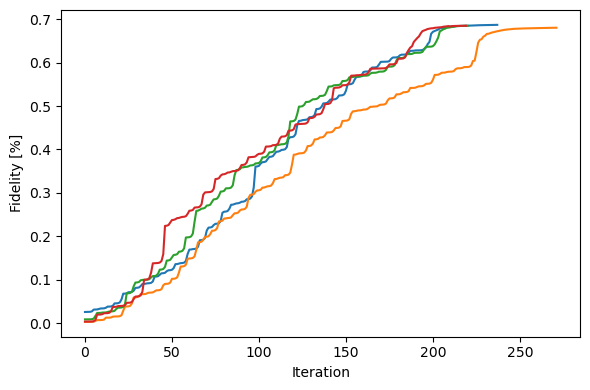

In [10]:
for i, opt_res in enumerate(ctrl_result.cost_history.iteration_values):
    plt.plot(1e2*(1-np.array(opt_res))) #, label=f'Trial {i}')
plt.xlabel('Iteration')
plt.ylabel('Fidelity [%]')
# plt.ylim(0, 1)
# plt.legend()
plt.tight_layout()
plt.show()

Convert controls dictionary into np arrays

In [51]:
# controls = dict()
# for q in range(len(qram.cutoffs)):
#     name = f'$\gamma_{q}$'
#     controls.update({name:result.output[name]})
# plot_controls(plt.figure(), controls, unit_symbol='GHz', polar=False)

Plot pi pulse qubit controls

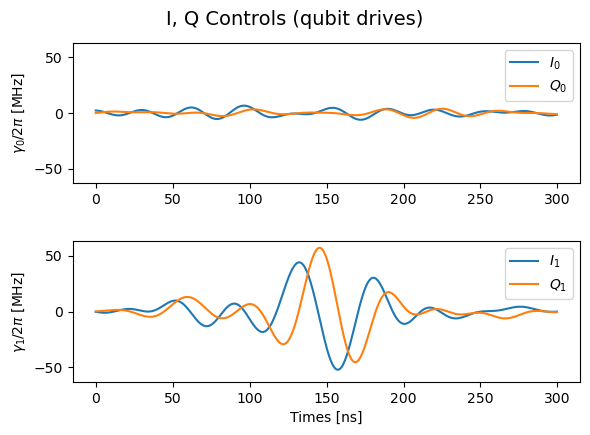

In [11]:
times_pi = []
I_values_pi = []
Q_values_pi = []
qubits_pi = []
for q in range(qram.nqubits):
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==0 and j==0: times_pi.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
    I_values_pi.append(I_values_q)
    Q_values_pi.append(Q_values_q)
    qubits_pi.append(q)

times_pi = np.array(times_pi)
I_values_pi = np.array(I_values_pi)
Q_values_pi = np.array(Q_values_pi)
qubits_pi = np.array(qubits_pi)

I_values = I_values_pi
Q_values = Q_values_pi
times = times_pi
plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))
for q in range(qram.nqubits):
    plt.subplot(int(f'41{q+1}'))
    plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
    plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

Plot sideband controls

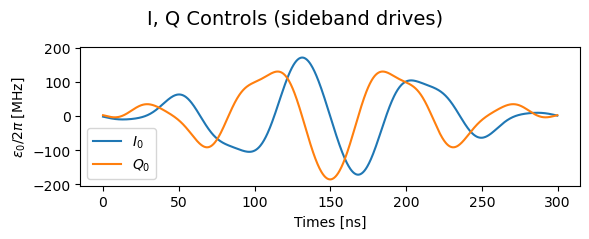

In [12]:
times_sb = []
I_values_sb = []
Q_values_sb = []
qubits_sb = []
for q in range(qram.nqubits):
    if q == 1: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\epsilon{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==0 and j==0: times_sb.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
    I_values_sb.append(I_values_q)
    Q_values_sb.append(Q_values_q)
    qubits_sb.append(q)

times_sb = np.array(times_sb)
I_values_sb = np.array(I_values_sb)
Q_values_sb = np.array(Q_values_sb)
qubits_sb = np.array(qubits_sb)

I_values = I_values_sb
Q_values = Q_values_sb
times = times_sb
plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (sideband drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))
for q in range(len(I_values)):
    plt.subplot(int(f'41{q+1}'))
    plt.plot(times, 1e3*I_values[q], label=f'$I_{q}$')
    plt.plot(times, 1e3*Q_values[q], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\epsilon_{q}/2\pi$ [MHz]')
    plt.legend()
plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

Plotting qctrl state evolution from different initial states

eg probabilty 0.992154733273557
gf probabilty 0.006871006318927228
gg probabilty 9.215337147917458e-05


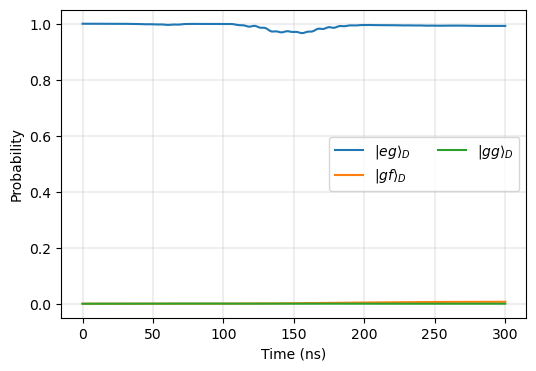

In [13]:
psi0 = 'eg'

state_result = ctrl_result.output[psi0]['value']
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(qt.Qobj(state_result[t])))**2 for t in range(len(sample_times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(sample_times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(sample_times, [0.5]*len(sample_times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

Plotting qctrl state evolution from test start state

eg probabilty 0.7362058735836026
gf probabilty 0.005150129142563702
gg probabilty 0.2579264683156061


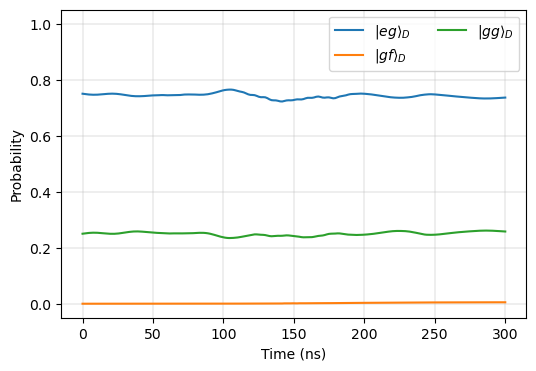

In [14]:
state_result = ctrl_result.output['sample_state']['value']
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(qt.Qobj(state_result[t])))**2 for t in range(len(sample_times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(sample_times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(sample_times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

# Qutip simulation of state evolution with optimal controls

If unrotate, do the simulation in the lab frame using optimal controls obtained from rotating frame.

In [15]:
unrotate = True 
rot_freq = frame_freq
phase = 0
if unrotate:
    rot_freq = 0

4.79254700717944
3.511449636426565
2.0841757489281125


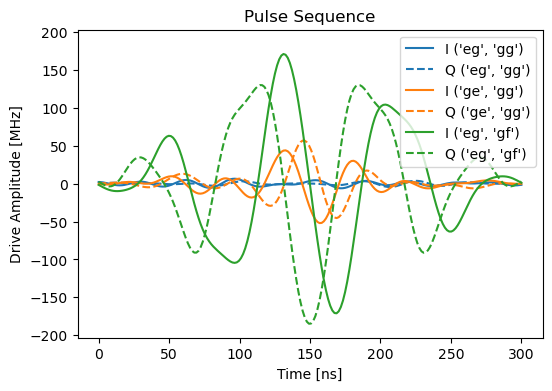

In [20]:
seq = PulseSequence(start_time=0)

for q in qubits_pi:
    gstate = 'g'*qram.nqubits
    estate = gstate[:q]+'e'+gstate[q+1:]
    seq.pulse_IQ(wd=2*np.pi*(qubit_freqs[q]-rot_freq), amp=1, pulse_levels=[gstate, estate], I_values=I_values_pi[q], Q_values=Q_values_pi[q], phase=phase, times=times_pi, drive_qubit=q, t_start=0)

for q in qubits_sb:
    gstate = 'g'*qram.nqubits
    eg_state = gstate[:q]+'e'+gstate[q+1:]
    gf_state = gstate[:1]+'f'+gstate[2:]
    seq.pulse_IQ(wd=2*np.pi*(freq_sb[q]-rot_freq), amp=1, pulse_levels=[eg_state, gf_state], I_values=I_values_sb[q], Q_values=Q_values_sb[q], phase=phase, times=times_sb, drive_qubit=1, t_start=0)

envelope_seq = seq.get_envelope_seq()
pulse_names = seq.get_pulse_names()
ymax = 0
for i, envelope in enumerate(envelope_seq):
    I_func, Q_func = envelope
    I_values = np.array([I_func(t)*1e3 for t in sample_times])
    Q_values = np.array([Q_func(t)*1e3 for t in sample_times])
    print(seq.pulse_freqs[i])
    plt.plot(sample_times, I_values, label=f'I {pulse_names[i]}', linestyle='-', color=default_colors[i])
    plt.plot(sample_times, Q_values, label=f'Q {pulse_names[i]}', linestyle='--', color=default_colors[i])
    ymax = max(ymax, max(abs(I_values)))
    ymax = max(ymax, max(abs(Q_values)))
ymax = 1.1*ymax
plt.xlabel('Time [ns]')
plt.ylabel('Drive Amplitude [MHz]')
plt.ylim(-ymax, ymax)
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [17]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'
# psi0 = qram.state(psi0_name)

psi0 = np.sqrt(0.25) * qram.state('gg') + np.sqrt(0.75) * qram.state('eg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('eggg') + np.sqrt(0.75) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('gggg') + np.sqrt(0.75) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())
times = sample_times

start_time = time.time()

print('Simulation in lab frame:', unrotate)
if unrotate:
    result = qram.evolve_unrotate(psi0=psi0, seq=seq, times=times, c_ops=None, nsteps=10000)
else:
    result = qram.evolve(psi0=psi0, seq=seq, times=times, H=qram.H_rot(2*np.pi*frame_freq), c_ops=None) #, nsteps=10000)
print("Run time (s):", time.time() - start_time, flush=True)

Simulation in lab frame: True
10.0%. Run time:  14.80s. Est. time left: 00:00:02:13
20.0%. Run time:  30.44s. Est. time left: 00:00:02:01
30.0%. Run time:  46.02s. Est. time left: 00:00:01:47
40.0%. Run time:  62.80s. Est. time left: 00:00:01:34
50.0%. Run time:  79.75s. Est. time left: 00:00:01:19
60.0%. Run time:  98.57s. Est. time left: 00:00:01:05
70.0%. Run time: 114.75s. Est. time left: 00:00:00:49
80.0%. Run time: 130.97s. Est. time left: 00:00:00:32
90.0%. Run time: 146.95s. Est. time left: 00:00:00:16
Total run time: 162.30s
Run time (s): 162.30600142478943


#### Plotting for 2Q

eg probabilty 0.7348890459640954
gf probabilty 0.009262427215891312
gg probabilty 0.2552462720390439


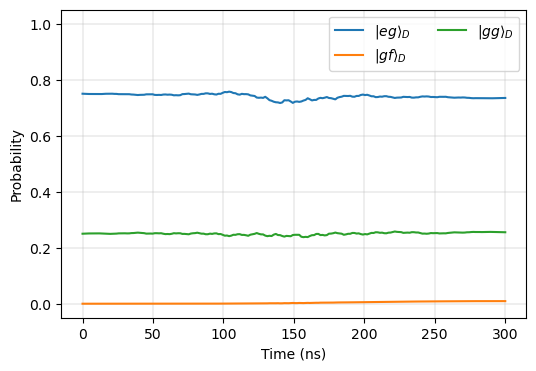

In [19]:
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(result[t]))**2 for t in range(len(times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

#### Plotting for 4Q

In [ ]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()